In [1]:
import math
from collections import defaultdict

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid, ModuleList, init
import torch.nn.functional as F
import torch_sparse
import numpy as np

import torch_geometric
from torch_geometric.utils import degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import to_dense_adj
from matplotlib import pyplot as plt

print("Modules loaded :)")

Modules loaded :)


In [2]:
data = Planetoid("datasets", "cora")[0]
x_norm = data.x / data.x.pow(2).sum(1).sqrt().unsqueeze(1)
edge_attr = torch.ones(data.edge_index.shape[1], 1)
deg = degree(data.edge_index[0], num_nodes=x_norm.size(0))
data["x"] = x_norm
data["edge_attr"] = edge_attr
data["deg"] = deg
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_attr=[10556, 1], deg=[2708])

In [53]:
## OLD VERSION ##
'''
class ResNet(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, alpha=0, L=2, Cw=2):
        super(ResNet, self).__init__()

        self.layers = ModuleList()
        for l in range(L+1):
            self.layers.append(
                Linear(
                    in_dim if (l==0) else hidden_dim,
                    out_dim if (l==L) else hidden_dim,
                    bias = False,
                )
            )

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.alpha = alpha
        self.L = L
        self.Cw = Cw
        self.relu = ReLU()

        self.reset_parameters()

    def reset_parameters(self):
        for l, layer in enumerate(self.layers):
            for p in layer.weight:
                std = math.sqrt(1.0 / self.in_dim) 
                if (l>0): std = math.sqrt(self.Cw / self.hidden_dim)
                init.normal_(p.data, mean=0, std=std)
            
    def forward(self, x):
        for l, layer in enumerate(self.layers):
            if l==0:
                x = layer(x)
            elif (l>0) and (l<self.L):
                x = self.alpha*x + layer(self.relu(x))
            else:
                x = layer(self.relu(x))
        return x
'''

'\nclass ResNet(nn.Module):\n    def __init__(self, in_dim, out_dim, hidden_dim, alpha=0, L=2, Cw=2):\n        super(ResNet, self).__init__()\n\n        self.layers = ModuleList()\n        for l in range(L+1):\n            self.layers.append(\n                Linear(\n                    in_dim if (l==0) else hidden_dim,\n                    out_dim if (l==L) else hidden_dim,\n                    bias = False,\n                )\n            )\n\n        self.in_dim = in_dim\n        self.out_dim = out_dim\n        self.hidden_dim = hidden_dim\n\n        self.alpha = alpha\n        self.L = L\n        self.Cw = Cw\n        self.relu = ReLU()\n\n        self.reset_parameters()\n\n    def reset_parameters(self):\n        for l, layer in enumerate(self.layers):\n            for p in layer.weight:\n                std = math.sqrt(1.0 / self.in_dim) \n                if (l>0): std = math.sqrt(self.Cw / self.hidden_dim)\n                init.normal_(p.data, mean=0, std=std)\n            \n  

In [3]:
class ResNet(nn.Module):
    """Fully connected NN w/ residual connections and Gaussian init
    Args:
    in_dim: input dimension
    out_dim: output dimension
    hidden_dim: width, hidden dimension
    alpha: strength of the residual connection
    L: depth, number of hidden layers
    Cw: variance scale for Gaussian init
    """

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        hidden_dim: int,
        alpha: float = 0,
        L: int = 2,
        Cw: float = 2,
    ):
        super(ResNet, self).__init__()

        self.layers = ModuleList()
        for layer in range(L + 1):
            self.layers.append(
                Linear(
                    in_dim if (layer == 0) else hidden_dim,
                    out_dim if (layer == L) else hidden_dim,
                    bias=False,
                )
            )

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.alpha = alpha
        self.L = L
        self.Cw = Cw
        self.relu = ReLU()

        self.reset_parameters()

    def reset_parameters(self):
        for layer, weights in enumerate(self.layers):
            for p in weights.weight:
                std = math.sqrt(1.0 / self.in_dim)
                if layer > 0:
                    std = math.sqrt(self.Cw / self.hidden_dim)
                init.normal_(p.data, mean=0, std=std)

    def forward(self, x: Tensor):
        for layer, weights in enumerate(self.layers):
            if layer == 0:
                x = weights(x)
            elif (layer > 0) and (layer < self.L):
                x = self.alpha * x + weights(self.relu(x))
            else:
                x = weights(self.relu(x))
        return x

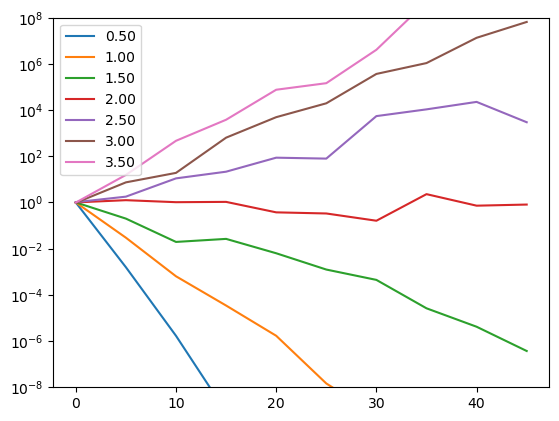

In [4]:
out = defaultdict(list)
x_norm = data.x / data.x.pow(2).sum(1).sqrt().unsqueeze(1)
L_vals = np.arange(0, 50, 5)
for L in L_vals:
    for Cw in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
        net = ResNet(data.x.shape[1], 128, 128, alpha=0, L=L, Cw=Cw)
        model_parameters = filter(lambda p: p.requires_grad, net.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        x_out = net(x_norm)
        mag = ((data.x.shape[1] / x_out.shape[1]) * x_out.pow(2).sum(1)).mean()
        out[Cw].append(mag.detach().numpy())

for Cw, d in out.items():
    plt.plot(L_vals, d, label=f"{Cw:.2f}")
plt.yscale("log")
plt.ylim([10**-8, 10**8])
plt.legend(loc="best")
plt.show()

In [56]:
## OLD VERSION ##
'''
class InteractionNetwork(MessagePassing):
    def __init__(self, node_dims, edge_dims, L=2, alpha=0, Cw=2.0):
        super(InteractionNetwork, self).__init__(aggr='add')
        
        self.edge_net = ResNet(
            edge_dims["in"] + 2*node_dims["in"], 
            edge_dims["out"], edge_dims["hidden"],
            L=L, alpha=alpha, Cw=Cw,
        )
        self.node_net = ResNet(
            node_dims["in"] + edge_dims["out"], 
            node_dims["out"], node_dims["hidden"],
            L=L, alpha=alpha, Cw=Cw,
        )
        self.edge_attr = Tensor()
    
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)
        return x, self.edge_attr

    def message(self, x_i, x_j, edge_attr):  
        m = torch.cat([x_i, x_j, edge_attr], dim=1) 
        self.edge_attr = self.edge_net(m) 
        return self.edge_attr
        
    def update(self, aggr_out, x):
        c = torch.cat([x, aggr_out], dim=1)
        return self.node_net(c) 

x_norm = data.x / data.x.pow(2).sum(1).sqrt().unsqueeze(1)
edge_attr = torch.ones(data.edge_index.shape[1],1)'''

'\nclass InteractionNetwork(MessagePassing):\n    def __init__(self, node_dims, edge_dims, L=2, alpha=0, Cw=2.0):\n        super(InteractionNetwork, self).__init__(aggr=\'add\')\n        \n        self.edge_net = ResNet(\n            edge_dims["in"] + 2*node_dims["in"], \n            edge_dims["out"], edge_dims["hidden"],\n            L=L, alpha=alpha, Cw=Cw,\n        )\n        self.node_net = ResNet(\n            node_dims["in"] + edge_dims["out"], \n            node_dims["out"], node_dims["hidden"],\n            L=L, alpha=alpha, Cw=Cw,\n        )\n        self.edge_attr = Tensor()\n    \n    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:\n        x = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)\n        return x, self.edge_attr\n\n    def message(self, x_i, x_j, edge_attr):  \n        m = torch.cat([x_i, x_j, edge_attr], dim=1) \n        self.edge_attr = self.edge_net(m) \n        return self.edge_attr\n        \n    def update(sel

In [5]:
class InteractionNetwork(MessagePassing):
    """Interaction network (IN) GNN layer
    Args:
    node_dims: dimension of node network, in the form
               {"in": in_dim, "hidden": hidden_dim, "out": out_dim}
    edge_dims: dimension of the edge network, in the form
               {"in": in_dim, "hidden": hidden_dim, "out": out_dim}
    L: depth of the ResNet node/edge networks
    alpha_node: res. connection strength in the node network
    alpha_edge: res. connection strength in the edge network
    Cw: variance scale for Gaussian init
    """

    def __init__(
        self,
        node_dims: int,
        edge_dims: int,
        L: int = 2,
        alpha_node: float = 0,
        alpha_edge: float = 0,
        Cw: float = 2.0,
    ):
        super(InteractionNetwork, self).__init__(aggr="add")

        self.edge_net = ResNet(
            edge_dims["in"] + 2 * node_dims["in"],
            edge_dims["out"],
            edge_dims["hidden"],
            L=L,
            alpha=alpha_edge,
            Cw=Cw,
        )
        self.node_net = ResNet(
            node_dims["in"] + edge_dims["out"],
            node_dims["out"],
            node_dims["hidden"],
            L=L,
            alpha=alpha_node,
            Cw=Cw,
        )
        self.edge_attr = Tensor()

    def forward(
        self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, deg: Tensor
    ) -> Tensor:
        # Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        #x = self.propagate(edge_index, x=x, edge_attr=edge_attr, deg=deg)
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr, norm=norm)
        return x, self.edge_attr

    def message(self, x_i, x_j, edge_attr, norm):
        m = torch.cat([x_i, x_j, edge_attr], dim=1) * norm.view(-1, 1)
        self.edge_attr = self.edge_net(m)
        return self.edge_attr

    def update(self, aggr_out, x):
        c = torch.cat([x, aggr_out], dim=1)
        return self.node_net(c)

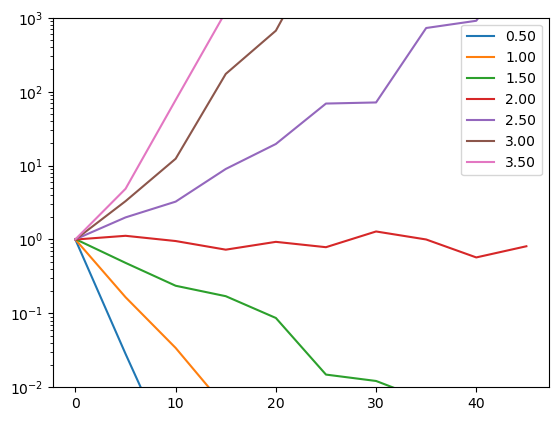

In [6]:
out = defaultdict(list)
L_vals = np.arange(0, 50, 5)
for L in L_vals:
    for Cw in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
        IN = InteractionNetwork(
            {"in": data.x.shape[1], "out": 128, "hidden": 256},
            {"in": 1, "out": 128, "hidden": 256},
            L=L, Cw=Cw,
        )
        model_parameters = filter(lambda p: p.requires_grad, IN.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        x_out, edge_attr_out = IN(x_norm, data.edge_index, edge_attr, deg)       
        mag = ((x_norm.shape[1] / x_out.shape[1]) * x_out.pow(2).sum(1)).sqrt().mean()
        out[Cw].append(mag.detach().float())

for Cw, d in out.items():
    plt.plot(L_vals, d, label=f"{Cw:.2f}") 
plt.yscale("log")
plt.ylim([10**-2, 10**3])
plt.legend(loc="best")
plt.show()

In [50]:
## OLD VERSION ##
'''
class IGNN(nn.Module):
    def __init__(
        self, node_dims, edge_dims, 
        L_internal=0, L=4, width=128,
        a_node=0, a_edge=0, Cw=2.0,
    ):
        super(IGNN, self).__init__()

        self.layers = ModuleList()
        for l in range(L+1):
            self.layers.append(
                InteractionNetwork(
                    node_dims = {
                        "in": node_dims["in"] if l==0 else node_dims["hidden"],
                        "out": node_dims["out"] if l==L else node_dims["hidden"],
                        "hidden": width,
                    },
                    edge_dims = {
                        "in": edge_dims["in"] if l==0 else edge_dims["hidden"],
                        "out": edge_dims["out"] if l==L else edge_dims["hidden"],
                        "hidden": width,
                    },
                    L=L_internal, alpha=0, Cw=Cw,
                )
            )

        self.width = width
        self.L = L
        self.L_internal = L_internal
        self.relu = ReLU()
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for l, layer in enumerate(self.layers):
            x, edge_attr = layer(x, edge_index, edge_attr)
            #x = x / x.pow(2).sum(1).sqrt().unsqueeze(1)
            #edge_attr = edge_attr / edge_attr.pow(2).sum(1).sqrt().unsqueeze(1)
        return x, edge_attr


ignn = IGNN(
    node_dims={"in": data.x.shape[1], "out": 64, "hidden": 64},
    edge_dims={"in": 1, "out": 1, "hidden": 64}, 
    L_internal=6, L=10, width=128,
    a_node=0, a_edge=0, Cw=2, 
)
data["edge_attr"] = edge_attr 
x_out, edge_attr_out = ignn(data)
print(x_out.pow(2).sum(1).mean())'''

'\nclass IGNN(nn.Module):\n    def __init__(\n        self, node_dims, edge_dims, \n        L_internal=0, L=4, width=128,\n        a_node=0, a_edge=0, Cw=2.0,\n    ):\n        super(IGNN, self).__init__()\n\n        self.layers = ModuleList()\n        for l in range(L+1):\n            self.layers.append(\n                InteractionNetwork(\n                    node_dims = {\n                        "in": node_dims["in"] if l==0 else node_dims["hidden"],\n                        "out": node_dims["out"] if l==L else node_dims["hidden"],\n                        "hidden": width,\n                    },\n                    edge_dims = {\n                        "in": edge_dims["in"] if l==0 else edge_dims["hidden"],\n                        "out": edge_dims["out"] if l==L else edge_dims["hidden"],\n                        "hidden": width,\n                    },\n                    L=L_internal, alpha=0, Cw=Cw,\n                )\n            )\n\n        self.width = width\n        sel

In [7]:
class IGNN(nn.Module):
    """GNN based on repeated interaction network (IN) convolutions
    Args:
    node_dims: node dims at input, intermediate, and output layers:
               {"in": in_dim, "hidden": hidden_dim, "out": out}
    edge_dims: edge dims at input, intermediate, and output layers:
               {"in": in_dim, "hidden": hidden_dim, "out": out}
    L: depth of the GNN, i.e. the number of IN layers
    L_internal: depth of the fully-connected NNs in each IN layer
    width: width of the node/edge networks in each IN layer
    Cw: variance scale for Gaussian init
    alpha_node: res. connection strength in each IN node network
    alpha_edge: res. connection strength in each IN edge network
    beta_node: res. connection strength between IN layers (node feats)
    beta_edge: res. connection strength between IN layers (edge feats)
    """

    def __init__(
        self,
        node_dims: int,
        edge_dims: int,
        L: int = 3,
        L_internal: int = 3,
        width: int = 128,
        alpha_node: float = 0,
        alpha_edge: float = 0,
        beta_node: float = 0,
        beta_edge: float = 0,
        Cw: float = 2.0,
    ):
        super(IGNN, self).__init__()

        self.layers = ModuleList()
        for layer in range(L + 1):
            l0 = layer == 0
            lL = layer == L
            self.layers.append(
                InteractionNetwork(
                    node_dims={
                        "in": node_dims["in"] if l0 else node_dims["hidden"],
                        "out": node_dims["out"] if lL else node_dims["hidden"],
                        "hidden": width,
                    },
                    edge_dims={
                        "in": edge_dims["in"] if l0 else edge_dims["hidden"],
                        "out": edge_dims["out"] if lL else edge_dims["hidden"],
                        "hidden": width,
                    },
                    L=L_internal,
                    Cw=Cw,
                    alpha_node=alpha_node,
                    alpha_edge=alpha_edge,
                )
            )
            
        self.L = L
        self.L_internal = L_internal
        self.width = width
        self.beta_node = beta_node
        self.beta_edge = beta_edge
        self.relu = ReLU()

    def forward(self, data):
        x, edge_index, edge_attr, deg = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.deg,
        )
        for layer, weights in enumerate(self.layers):
            x_new, edge_attr_new = weights(x, edge_index, edge_attr, deg)
            x_new = x_new / x_new.pow(2).sum(1).sqrt().unsqueeze(1)
            edge_attr_new = (
                edge_attr_new
                / edge_attr_new.pow(2).sum(1).sqrt().unsqueeze(1)
            )
            if layer>0 and layer<self.L:
                x = x + self.beta_node * x_new
                edge_attr = edge_attr + self.beta_edge * edge_attr_new
            else:
                x = x_new
                edge_attr = edge_attr_new
        return x, edge_attr
    
ignn = IGNN(
    node_dims={"in": data.x.shape[1], "out": 64, "hidden": 64},
    edge_dims={"in": 1, "out": 1, "hidden": 64}, 
    L_internal=6, L=10, width=128,
    alpha_node=0, alpha_edge=0, Cw=2, 
)
data["edge_attr"] = edge_attr 
x_out, edge_attr_out = ignn(data)
print(x_out.pow(2).sum(1).mean())

tensor(1., grad_fn=<MeanBackward0>)
